In [ ]:
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from matplotlib.colors import cnames
import multiprocessing
from multiprocessing import Process, Manager
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")


### No need to run

In [ ]:
# key_wanted = ["EPOCH", "SEMIMAJOR_AXIS", "INCLINATION", "MEAN_MOTION", "ECCENTRICITY", "RA_OF_ASC_NODE",
#               "ARG_OF_PERICENTER", "MEAN_ANOMALY", "BSTAR", "MEAN_MOTION_DOT", "MEAN_MOTION_DDOT", "PERIOD", "APOGEE", "PERIGEE"]
key_wanted = ["EPOCH", "SEMIMAJOR_AXIS","INCLINATION"]
satcat=pd.read_csv("./data/satcat.csv")
starttime=datetime.strptime("2022-4-1 0:0:0","%Y-%m-%d %H:%M:%S")
endtime=datetime.strptime("2022-7-20 0:0:0","%Y-%m-%d %H:%M:%S")
path="../../TLE/all_by_id_latest/"
figurepath="../../figures/payload/"
earth_R=6378.14

In [ ]:
data={'starlink':{'alt':[],'inc':[]},'others':{'alt':[],'inc':[]},'oneweb':{'alt':[],'inc':[]},'iridium':{'alt':[],'inc':[]},'debris':{'alt':[],'inc':[]},'rocket':{'alt':[],'inc':[]}}
for row in tqdm(satcat.itertuples()):
    object_type=row.OBJECT_TYPE
    satid=row.NORAD_CAT_ID
    object_name=row.OBJECT_NAME
    filepath=path+str(satid)+".csv"
    try:
        tempdf=pd.read_csv(filepath)
    except:
        continue
    tempdf['EPOCH'] = tempdf['EPOCH'].astype('datetime64[ns]')
    tempdf['SEMIMAJOR_AXIS'] = tempdf['SEMIMAJOR_AXIS'].astype('float')
    tempdf['altitude']=tempdf.apply(lambda x:x['SEMIMAJOR_AXIS']-earth_R,axis=1)
    
    tempdf=tempdf[((tempdf['EPOCH']>starttime)&(tempdf['EPOCH']<endtime))]
    if tempdf.shape[0]==0:
        continue
    tempdf=tempdf.sort_values(by="EPOCH")
    tempdf=tempdf.drop_duplicates(subset=['EPOCH'])
    


    if 'ONEWEB' in object_name and object_type=='PAYLOAD':
        data['oneweb']['alt'].append(np.std(tempdf['altitude']))
        data['oneweb']['inc'].append(np.std(tempdf['INCLINATION']))
    elif 'IRIDIUM' in object_name and object_type=='PAYLOAD':
        data['iridium']['alt'].append(np.std(tempdf['altitude']))
        data['iridium']['inc'].append(np.std(tempdf['INCLINATION']))
    elif 'STARLINK' in object_name and object_type=='PAYLOAD' and np.median(tempdf['SEMIMAJOR_AXIS'])>earth_R+550-30 and np.median(tempdf['SEMIMAJOR_AXIS'])<earth_R+550+30:
        data['starlink']['alt'].append(np.std(tempdf['altitude']))
        data['starlink']['inc'].append(np.std(tempdf['INCLINATION']))
    elif object_type=='PAYLOAD' and np.median(tempdf['SEMIMAJOR_AXIS'])>earth_R+550-30 and np.median(tempdf['SEMIMAJOR_AXIS'])<earth_R+550+30:
        data['others']['alt'].append(np.std(tempdf['altitude']))
        data['others']['inc'].append(np.std(tempdf['INCLINATION']))
    elif object_type=='DEBRIS' and np.median(tempdf['SEMIMAJOR_AXIS'])>earth_R+550-30 and np.median(tempdf['SEMIMAJOR_AXIS'])<earth_R+550+30:
        data['debris']['alt'].append(np.std(tempdf['altitude']))
        data['debris']['inc'].append(np.std(tempdf['INCLINATION']))
    elif object_type=='ROCKET BODY' and np.median(tempdf['SEMIMAJOR_AXIS'])>earth_R+550-30 and np.median(tempdf['SEMIMAJOR_AXIS'])<earth_R+550+30:
        data['rocket']['alt'].append(np.std(tempdf['altitude']))
        data['rocket']['inc'].append(np.std(tempdf['INCLINATION']))            
        
    # 画图相关
            # for item in key_wanted[2:]:
            #     tempdf[item] = tempdf[item].astype('float')
            # elements = {}
            # for item in key_wanted:
            #     elements[item] = tempdf[item]
            # figure, ax = plt.subplots(len(key_wanted)-1, 1,
            #                         figsize=(8, 2*len(key_wanted)-2),
            #                         # 共享x轴
            #                         sharex=True)
            # for i in range(1, len(key_wanted)):
            #     ax[i-1].plot(elements[key_wanted[0]], elements[key_wanted[i]],
            #                 label=key_wanted[i], c=list(cnames.keys())[i+25])  # +25因为这段是dark
            #     ax[i-1].legend()
            #     if key_wanted[i]=="INCLINATION":
            #         m=np.median(elements[key_wanted[i]])
            #         ax[i-1].set_ylim(m-0.03,m+0.03) #倾角极差
            #     elif key_wanted[i]=="SEMIMAJOR_AXIS":
            #         m=np.median(elements[key_wanted[i]])
            #         ax[i-1].set_ylim(m-5,m+5) #倾角极差
        
            # plt.xlim(starttime,endtime)
            # plt.xlabel(object_name)
            # plt.tight_layout()
            # plt.savefig(figurepath+str(satid)+'.pdf')
            # plt.close()
            # print(str(satid)+ " : got figure")
            # break
    

### Start from this line

In [5]:
# np.save('std.npy',data)
data=np.load('./data/std.npy', allow_pickle=True).item()

In [6]:
alt=[data['starlink']['alt'],data['others']['alt'],data['debris']['alt']+data['rocket']['alt'],data['oneweb']['alt'],data['iridium']['alt']]
inc=[data['starlink']['inc'],data['others']['inc'],data['debris']['inc']+data['rocket']['inc'],data['oneweb']['inc'],data['iridium']['inc']]

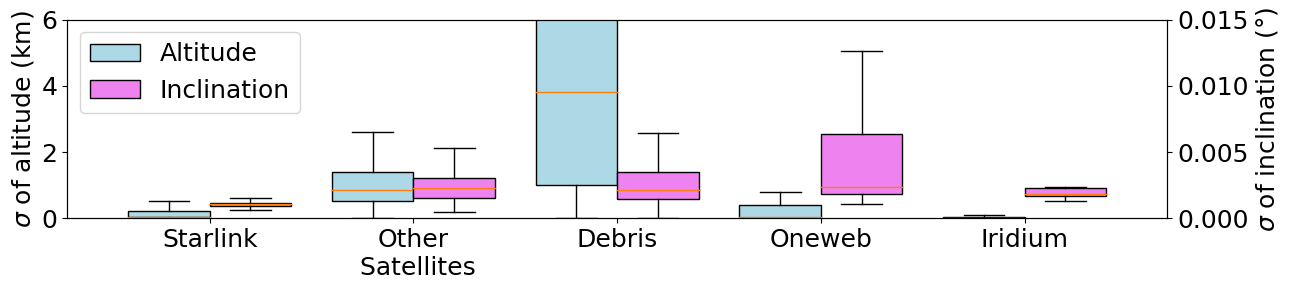

In [7]:
fig, ax = plt.subplots(figsize=(13,3))
plt.ylim(0, 6)
green_diamond = dict(markerfacecolor='lightgreen', marker='D')
positions2=[1.4,2.4,3.4,4.4,5.4]
loc=[1.2,2.2,3.2,4.2,5.2]
x=['Starlink','Other\n Satellites','Debris','Oneweb','Iridium']
temp=ax.boxplot(alt,flierprops=green_diamond,patch_artist=True,showfliers = False,widths=0.4) 
plt.ylabel("$\sigma$ of altitude (km)",fontsize=18)
ax.tick_params(labelsize=18)
ax2 = ax.twinx()
plt.ylim(0, 0.015)
for patch in temp['boxes']:
    patch.set_facecolor("lightblue")
temp2=ax2.boxplot(inc,flierprops=green_diamond,patch_artist=True,showfliers = False,positions=positions2,widths=0.4) 
for patch in temp2['boxes']:
    patch.set_facecolor("violet")
plt.xticks(loc,x)
plt.ylabel("$\sigma$ of inclination ($\degree$)",fontsize=18)
ax2.tick_params(labelsize=18)
ax.legend([temp["boxes"][0], temp2["boxes"][0]], ['Altitude', 'Inclination'], loc='upper left',fontsize=18)
# y_major_locator=MultipleLocator(4)

# plt.xlabel("Objects",fontsize=18)



plt.tight_layout()
plt.savefig("std-v3.pdf")

plt.show()